In [1]:
import re
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import Normalize, PowerNorm
import seaborn as sns
%matplotlib inline

# Результаты паракрана

Здесь можно подставить идентификатор любого другого паркрана.

In [2]:
parkrun = 'kuzminki'

Список идентификаторов всех российских паркранов находится в файле `russian_parkruns.csv`.

Какие результаты получить - последние или же по конкретному номеру (закомментировать одну из строк с `suff`):

In [3]:
suff = '/latestresults/'  # результаты последнего паркрана, внесённого в систему

In [4]:
N = 100  # либо указываем номер и раскомментируем следующую строчку

In [5]:
# suff = f'/weeklyresults/?runSeqNumber={N}'

In [6]:
url = f'https://www.parkrun.ru/{parkrun}/results' + suff
page_all_results = requests.get(url, headers={'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:86.0) Gecko/20100101 Firefox/86.0'})

In [7]:
data = pd.read_html(page_all_results.text)[0]
unknown_runners = len(data[data['Участник'] == 'Неизвестный'])
number_runners = len(data)
data = data.dropna(thresh=3)

In [8]:
# Общее количество участников забега
number_runners

76

In [9]:
# Количество "неизвестных" участников в данном забеге
unknown_runners

10

In [10]:
data['Позиция м/ж'] = data[data.columns[2]].dropna().transform(lambda s: int(re.search(r'(?:Мужской|Женский)[ ]+(\d+)', s)[1]))
data[data.columns[2]] = data[data.columns[2]].dropna().transform(lambda s: re.search(r'Мужской|Женский', s)[0])

data[data.columns[1]] = data[data.columns[1]].transform(lambda s: re.search(r'([^\d]+)\d.*|Неизвестный', s)[1])

data[data.columns[3]] = data[data.columns[3]].dropna().transform(lambda s: re.search(r'\w\w\d\d-\d\d|\w\w10|\w\w---', s)[0])

data['Личник'] = data[data.columns[5]].dropna().transform(lambda s: re.search(r'(?<=\d\d:\d\d)(.*)', s)[1])
data[data.columns[5]] = data[data.columns[5]].dropna().transform(lambda s: re.search(r'^(\d:)?\d\d:\d\d', s)[0])

#data['Клуб'].fillna('',inplace=True)

In [11]:
data

,Позиция,Участник,Пол,Возр. группа,Клуб,Время,Позиция м/ж,Личник
0,1,Алексей МИЛОВЗОРОВ,Мужской,СМ25-29,Wake&Run,18:46,1,ЛР 18:11
1,2,Егор МИТЕРЁВ,Мужской,СМ30-34,Orienta-Kuncevo,19:00,2,ЛР 18:11
2,3,Андрей ЧИВИН,Мужской,ВМ40-44,Wake&Run,19:19,3,ЛР 18:27
4,5,Руслан НАВРУЗБЕКОВ,Мужской,СМ30-34,NaN,19:36,4,ЛР 19:01
5,6,Сергей ВЕГЕЛЬ,Мужской,ВМ35-39,Wake&Run,19:53,5,Новый ЛР!
...,...,...,...,...,...,...,...,...
71,72,Сергей КИРИАКИДИ,Мужской,СМ30-34,Wake&Run,47:47,43,ЛР 19:47
72,73,Лариса НОВИКОВА,Женский,ВЖ50-54,NaN,48:35,20,ЛР 45:16
73,74,Любовь КАЗАНЦЕВА,Женский,ВЖ60-64,NaN,48:39,21,ЛР 43:53
74,75,Дарья РЯБЧИКОВА,Женский,СЖ20-24,NaN,48:40,22,ЛР 35:33


In [12]:
data['result_m'] = data['Время'].transform(lambda time: sum(x * int(t) for x, t in zip([1/60, 1, 60], time.split(':')[::-1])))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 0 to 75
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Позиция       66 non-null     int64  
 1   Участник      66 non-null     object 
 2   Пол           66 non-null     object 
 3   Возр. группа  66 non-null     object 
 4   Клуб          27 non-null     object 
 5   Время         66 non-null     object 
 6   Позиция м/ж   66 non-null     int64  
 7   Личник        66 non-null     object 
 8   result_m      66 non-null     float64
dtypes: float64(1), int64(2), object(6)
memory usage: 5.2+ KB


In [13]:
data.isnull().sum()

Позиция          0
Участник         0
Пол              0
Возр. группа     0
Клуб            39
Время            0
Позиция м/ж      0
Личник           0
result_m         0
dtype: int64

In [14]:
data['result_m'].describe()

count    66.000000
mean     27.484596
std       7.556075
min      18.766667
25%      22.079167
50%      25.158333
75%      30.445833
max      48.683333
Name: result_m, dtype: float64

### Топ3 мужчины и женщины

In [15]:
data[data['Позиция м/ж'] < 4].drop(data.iloc[:,[0,2,3,4,7,8]], axis=1)

,Участник,Время,Позиция м/ж
0,Алексей МИЛОВЗОРОВ,18:46,1
1,Егор МИТЕРЁВ,19:00,2
2,Андрей ЧИВИН,19:19,3
15,Светлана БЕЛАВИНА,21:40,1
17,Екатерина КАРАМЫШЕВА,21:59,2
29,Анастасия ГАРКУЛЬ,24:19,3


Медианное время

In [16]:
data['result_m'].median()

25.15833333333333

Квантиль

In [17]:
q = data['result_m'].quantile(q=0.95)
q

48.38333333333333

## Распределение участников по полу

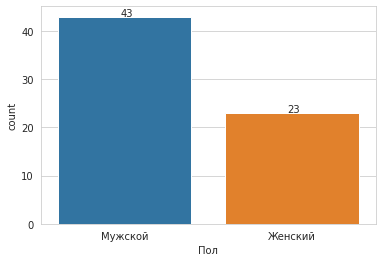

In [18]:
sns.set_style('whitegrid')
ax = sns.countplot(x='Пол', data=data)
for p, label in zip(ax.patches, data['Пол'].value_counts().values):
    ax.annotate(label, (p.get_x()+0.375, p.get_height()+0.15))

## Количество участников из беговых клубов

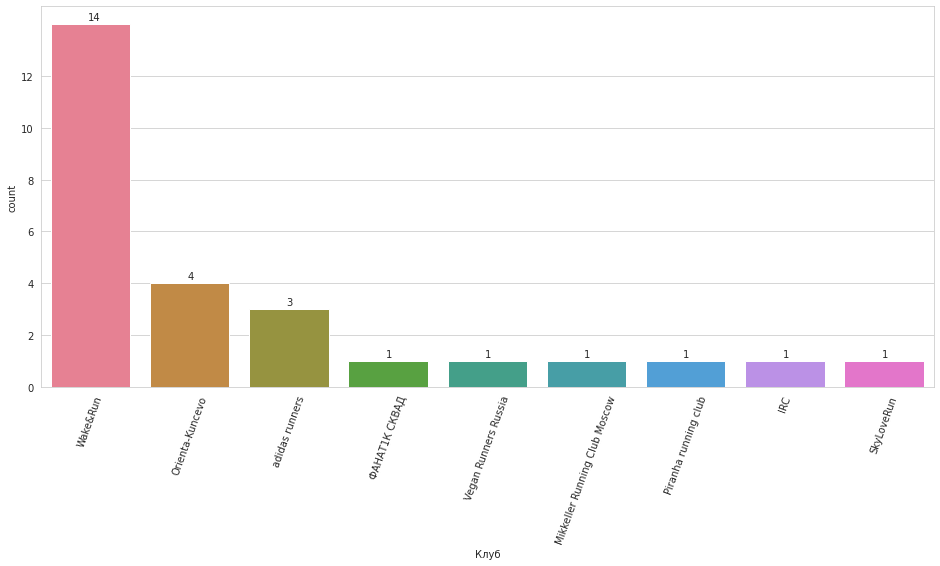

In [19]:
clubs = data['Клуб'].value_counts()
plt.figure(figsize=(16, 7))
plt.xticks(rotation=70)
sns.set_style('whitegrid')
plt.yticks(list(range(0, clubs[0], 2)))
ax = sns.countplot(x='Клуб', data=data, palette='husl', order=clubs.index)
for p, label in zip(ax.patches, clubs.values):
    ax.annotate(label, (p.get_x()+0.375, p.get_height()+0.15))

In [20]:
clubs = data['Клуб'].value_counts()
colors = [('blueviolet' if item == 'Wake&Run' else 'darkkhaki') for item in clubs.index]

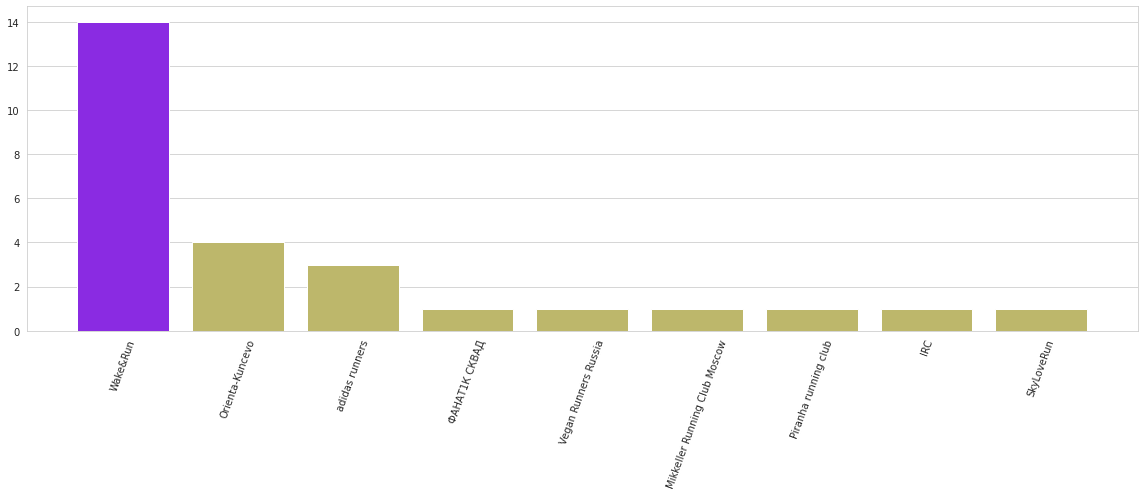

In [21]:
fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot()
ax.grid(False, axis='x')
ax.yaxis.set_major_locator(MultipleLocator(2))

plt.xticks(rotation=70)
plt.bar(clubs.index,clubs.values, color=colors)
plt.tight_layout()

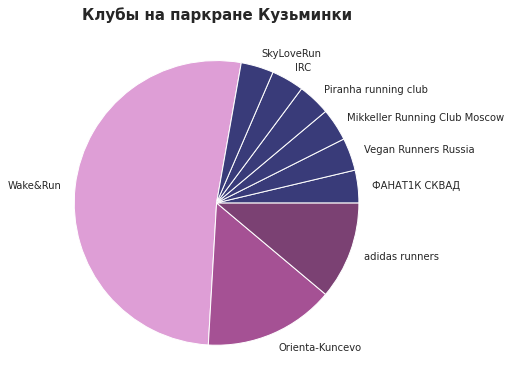

In [22]:
norm = PowerNorm(gamma=0.1)
colors = plt.cm.tab20b(norm(clubs.values))
fig = plt.figure(figsize=(7, 7))
plt.pie(clubs.values, labels=clubs.index, colors=colors, startangle=80)
plt.title('Клубы на паркране Кузьминки', size=15, fontweight='bold')
plt.tight_layout()

## Распределение по возрастным группам

Rectangle(xy=(-0.4, 0), width=0.4, height=17, angle=0)


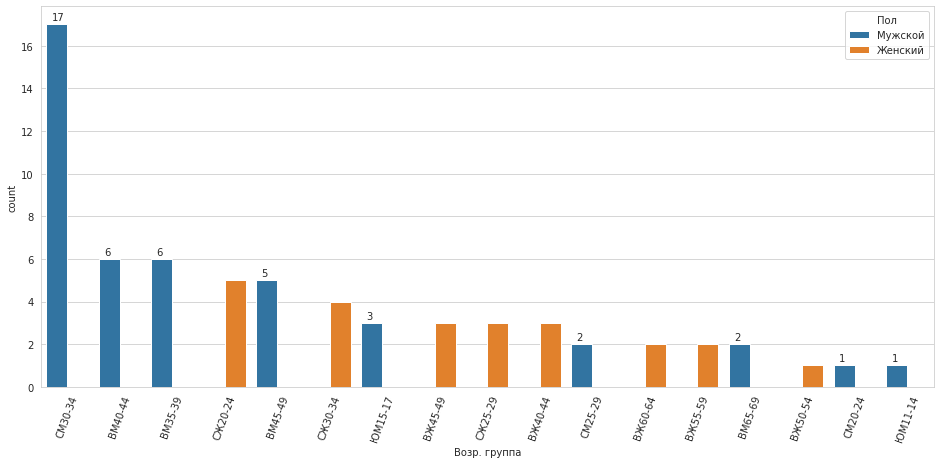

In [23]:
age_groups = data['Возр. группа'].value_counts()
plt.figure(figsize=(16, 7))
plt.xticks(rotation=70)
sns.set_style('whitegrid')
ax = sns.countplot(data=data, x='Возр. группа', hue='Пол', palette='tab10', order=age_groups.index)
print(ax.patches[0])
for p, label in zip(ax.patches, age_groups.values):
    ax.annotate(label, (p.get_x()+0.1, p.get_height()+0.2))

### Распределение результатов участников

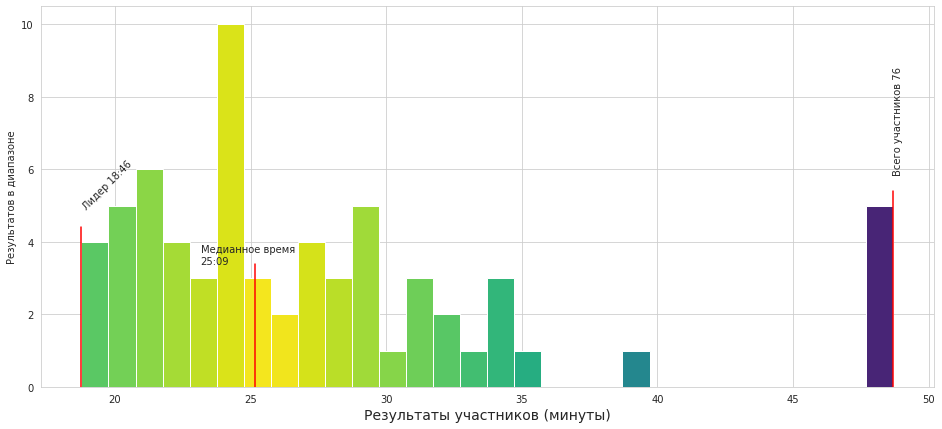

In [24]:
plt.figure(figsize=(16, 7))
ax = data['result_m'].hist(bins=30)
ptchs = ax.patches
med = data['result_m'].median()
norm = Normalize(0, med)

for ptch in ptchs:
    ptch_x = ptch.get_x()
    color = plt.cm.viridis(norm(med - abs(med - ptch_x)))
    ptch.set_facecolor(color)
    if ptch_x <= med:
        m_height = ptch.get_height() + 0.4
    

ax.set_xlabel("Результаты участников (минуты)", size=14)
ax.set_ylabel("Результатов в диапазоне")

ax.annotate(f'Медианное время\n{int(med)}:{(med-int(med))*60:02.0f}', (med-2, m_height))
plt.plot([med,med],[0,m_height], 'r')

ldr_time = ptchs[0].get_x()
ldr_y_mark = ptchs[0].get_height() + 0.4
ax.annotate(f'Лидер {int(ldr_time)}:{(ldr_time-int(ldr_time))*60:02.0f}', (ldr_time, ldr_y_mark+0.5), rotation=45)
plt.plot([ldr_time,ldr_time],[0,ldr_y_mark], 'r')

lst_time = ptchs[-1].get_x() + ptchs[-1].get_width()
lst_y_mark = ptchs[-1].get_height() + 0.4
ax.annotate(f'Всего участников {number_runners}', (lst_time, lst_y_mark+0.5), rotation=90)
plt.plot([lst_time,lst_time],[0,lst_y_mark], 'r')

# plt.tight_layout()
# plt.savefig('results.png')

Время лидера по женщинам

In [25]:
w_res = data[data['Пол'].str.contains('Женский')].reset_index(drop=True)
w_res['result_m'][0]

21.666666666666668

In [26]:

personal_res = data[data['Участник'].str.contains('Усаче'.upper())].reset_index(drop=True)
personal_res
# if not personal_res.empty:
#     personal_res = personal_res['result_m'][0]

,Позиция,Участник,Пол,Возр. группа,Клуб,Время,Позиция м/ж,Личник,result_m
